## Importing libraries and loading the dataset

In [ ]:
!pip install pytorch-fid -q

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
batch_size = 64
latent_dim = 64
lr = 0.001
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Loading MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 101491307.77it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38407005.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31594993.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6392794.89it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## FID Score

In [ ]:
import shutil
from torch.utils.data import SubsetRandomSampler
import os
import numpy as np

TOTAL_SAMPLES = 5000
ORIGINAL_DIR = 'original_samples'
GENERATED_DIR = 'generated_samples'

to_pil = transforms.ToPILImage()

test_indices = np.random.choice(len(test_dataset), TOTAL_SAMPLES, replace=False)
test_sampler = SubsetRandomSampler(test_indices)
fid_test_dataloader = DataLoader(test_dataset, batch_size=1, sampler=test_sampler)

if os.path.exists(ORIGINAL_DIR):
    shutil.rmtree(ORIGINAL_DIR)
os.mkdir(ORIGINAL_DIR)

for i, batch in enumerate(fid_test_dataloader):
    path = f'test_{i}.png'
    image = batch[0][0] * 255
    image = to_pil(image.byte())
    path = os.path.join(ORIGINAL_DIR, path)
    image.save(path)


In [68]:
z = torch.randn(len(fid_test_dataloader), latent_dim).to(device)
@torch.no_grad()
def save_fid_samples(model):
    if os.path.exists(GENERATED_DIR):
        shutil.rmtree(GENERATED_DIR)
    os.mkdir(GENERATED_DIR)
    model.eval()
    for i, batch in enumerate(fid_test_dataloader):
        path = f'test_{i}.png'
        z = torch.randn(1, latent_dim).to(device)
        x_hat, *_ = model(z)
        x_hat = torch.round(x_hat)
        image = x_hat[0] * 255
        image = to_pil(image.byte())
        path = os.path.join(GENERATED_DIR, path)
        image.save(path)

In [ ]:
from pytorch_fid import fid_score as FID

def calculate_fid(model):
    save_fid_samples(model)
    fid_score = FID.calculate_fid_given_paths([ORIGINAL_DIR, GENERATED_DIR], batch_size=batch_size, device=device, dims=2048)
    return fid_score

# Defining discriminator and generator classes for GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(64, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 16*196),
            nn.BatchNorm1d(16*196),
            nn.ReLU(),

            nn.Unflatten(1, (16*196, 1, 1)),
            nn.PixelShuffle(14),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.PixelShuffle(2),
            nn.Conv2d(8, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.network(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, padding=1, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
#testing if the structure is OK
x = torch.randn(4, 1, 28, 28)
dis = Discriminator()
result = dis(x)

In [ ]:
result.shape

torch.Size([4, 1])

In [ ]:
result.shape

torch.Size([4, 1])

In [ ]:
z = torch.randn(4, 64)
generator = Generator()
fake = generator(z)

In [ ]:
fake.shape

torch.Size([4, 1, 28, 28])

## Training the GAN

In [ ]:
@torch.no_grad()
def generate_and_plot_images(generator):
    generator.eval()
    z = torch.randn(25, latent_dim).to(device)
    generated_images = generator(z).detach().cpu().numpy()
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=(5, 5))
    for j in range(25):
        plt.subplot(5, 5, j+1)
        plt.imshow(generated_images[j, 0, :, :], cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
generator_gan = Generator().to(device)
discriminator_gan = Discriminator().to(device)

optimizer_G = optim.Adam(generator_gan.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator_gan.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

Epoch [0/10], Step [0   /937],Discriminator Loss: 1.3964,Generator Loss: 0.5724
Epoch [0/10], Step [500 /937],Discriminator Loss: 0.3949,Generator Loss: 1.8571


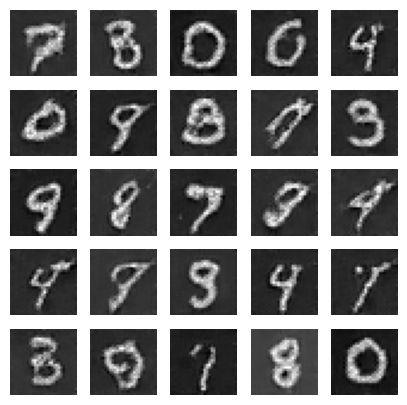

Epoch [1/10], Step [0   /937],Discriminator Loss: 1.2208,Generator Loss: 0.3788
Epoch [1/10], Step [500 /937],Discriminator Loss: 0.6254,Generator Loss: 2.1737
Epoch [2/10], Step [0   /937],Discriminator Loss: 0.5773,Generator Loss: 2.3285
Epoch [2/10], Step [500 /937],Discriminator Loss: 0.5799,Generator Loss: 1.8895
Epoch [3/10], Step [0   /937],Discriminator Loss: 0.5431,Generator Loss: 2.7881
Epoch [3/10], Step [500 /937],Discriminator Loss: 0.4979,Generator Loss: 2.0392
Epoch [4/10], Step [0   /937],Discriminator Loss: 0.7847,Generator Loss: 1.8546
Epoch [4/10], Step [500 /937],Discriminator Loss: 0.6908,Generator Loss: 1.3253
Epoch [5/10], Step [0   /937],Discriminator Loss: 0.5435,Generator Loss: 2.5384
Epoch [5/10], Step [500 /937],Discriminator Loss: 0.5831,Generator Loss: 1.8785


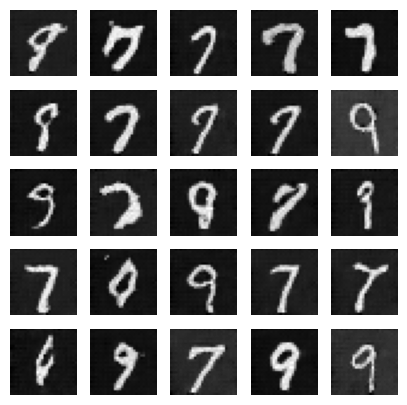

Epoch [6/10], Step [0   /937],Discriminator Loss: 0.6313,Generator Loss: 2.0175
Epoch [6/10], Step [500 /937],Discriminator Loss: 0.5895,Generator Loss: 2.1272
Epoch [7/10], Step [0   /937],Discriminator Loss: 0.5887,Generator Loss: 2.3316
Epoch [7/10], Step [500 /937],Discriminator Loss: 0.4859,Generator Loss: 3.1324
Epoch [8/10], Step [0   /937],Discriminator Loss: 0.4840,Generator Loss: 2.8809
Epoch [8/10], Step [500 /937],Discriminator Loss: 0.6074,Generator Loss: 2.3897
Epoch [9/10], Step [0   /937],Discriminator Loss: 0.4306,Generator Loss: 2.8399
Epoch [9/10], Step [500 /937],Discriminator Loss: 0.5434,Generator Loss: 2.5839


In [ ]:
losses_G = []
losses_D = []
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        #We add the sigmoid layer here cause normal GAN ends with a sigmoid.
        #But as the structure for WGAN for next part is the same as GAN we just won't add the sigmoid layer.
        real_output = torch.sigmoid(discriminator_gan(real_images))
        loss_real = criterion(real_output, real_labels)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator_gan(z)
        fake_output = torch.sigmoid(discriminator_gan(fake_images.detach()))
        loss_fake = criterion(fake_output, fake_labels)

        # Discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Training Generator
        optimizer_G.zero_grad()
        fake_output = torch.sigmoid(discriminator_gan(fake_images))
        loss_G = criterion(fake_output, real_labels)
        loss_G.backward()
        optimizer_G.step()

        #printing generator and discriminator losses every 500 steps in one epoch
        if i % 500 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i:<4}/{len(train_loader)}],"
                  f"Discriminator Loss: {loss_D.item():.4f},Generator Loss: {loss_G.item():.4f}")

    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    #show generated images in the beginning and middle of training
    if (epoch == 0) or (epoch == epochs/2):
        generate_and_plot_images(generator_gan)

In [ ]:
def plot_loss(losses_G, losses_D):
    plt.plot(losses_G, label='Generator Loss')
    plt.plot(losses_D, label='Discriminator Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.show()

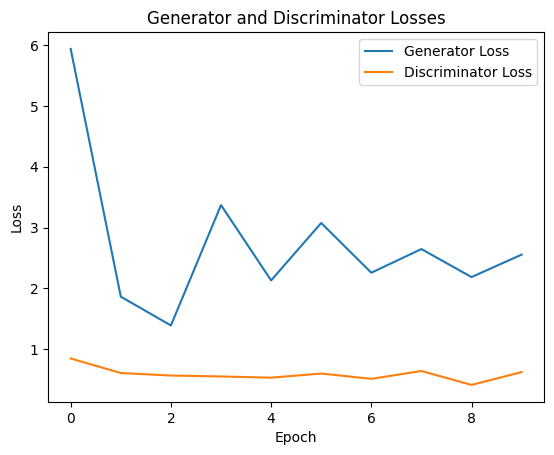

In [ ]:
plot_loss(losses_G, losses_D)

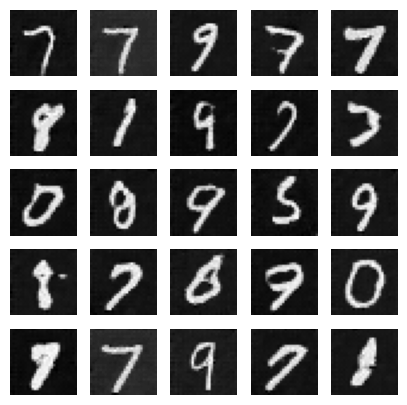

In [ ]:
#showing generated images after training
generate_and_plot_images(generator_gan)

## Validating our GAN

In [69]:
fid_value = calculate_fid(generator_gan)
print(f"FID Score: {fid_value}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 207MB/s]
100%|██████████| 79/79 [00:17<00:00,  4.57it/s]


FID Score: 57.59056270321483


# WGAN

## Training the WGAN

The WGAN has the previous arcitecture so we don't define new classes.

In [50]:
generator_wgan = Generator().to(device)
discriminator_wgan = Discriminator().to(device)

optimizer_G = optim.Adam(generator_wgan.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator_wgan.parameters(), lr=lr, betas=(0.5, 0.999))
#We use torch.mean for loss

Epoch [0/10],Step [0   /937],Discriminator Loss: 0.0068, Generator Loss: 0.0125
Epoch [0/10],Step [500 /937],Discriminator Loss: 0.1015, Generator Loss: 0.1453


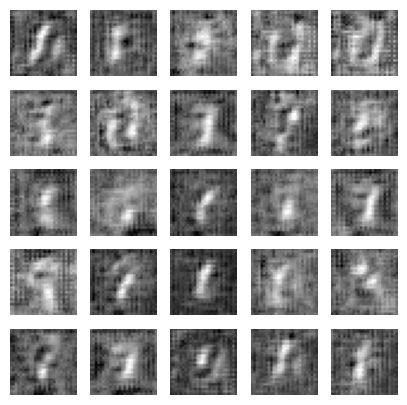

Epoch [1/10],Step [0   /937],Discriminator Loss: -0.0358, Generator Loss: 1.0153
Epoch [1/10],Step [500 /937],Discriminator Loss: -0.0000, Generator Loss: 0.0100
Epoch [2/10],Step [0   /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [2/10],Step [500 /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [3/10],Step [0   /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [3/10],Step [500 /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [4/10],Step [0   /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [4/10],Step [500 /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [5/10],Step [0   /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [5/10],Step [500 /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100


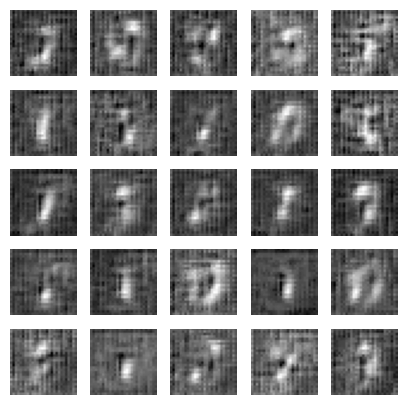

Epoch [6/10],Step [0   /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [6/10],Step [500 /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [7/10],Step [0   /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [7/10],Step [500 /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [8/10],Step [0   /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [8/10],Step [500 /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [9/10],Step [0   /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100
Epoch [9/10],Step [500 /937],Discriminator Loss: 0.0000, Generator Loss: 0.0100


In [51]:
losses_G = []
losses_D = []
clip_value = 0.01

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        optimizer_D.zero_grad()
        real_output = discriminator_wgan(real_images)
        loss_real = -torch.mean(real_output)
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator_wgan(z)
        fake_output = discriminator_wgan(fake_images.detach())
        loss_fake = torch.mean(fake_output)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Clip weights of the critic
        for p in discriminator_wgan.parameters():
            p.data.clamp_(-clip_value, clip_value)

        optimizer_G.zero_grad()
        fake_output = discriminator_wgan(fake_images)
        loss_G = -torch.mean(fake_output)
        loss_G.backward()
        optimizer_G.step()

        if i % 500 == 0:
            print(f"Epoch [{epoch}/{epochs}],Step [{i:<4}/{len(train_loader)}],"
                  f"Discriminator Loss: {loss_D.item():.4f}, Generator Loss: {loss_G.item():.4f}")

    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    if (epoch == 0) or (epoch == epochs/2):
        generate_and_plot_images(generator_wgan)

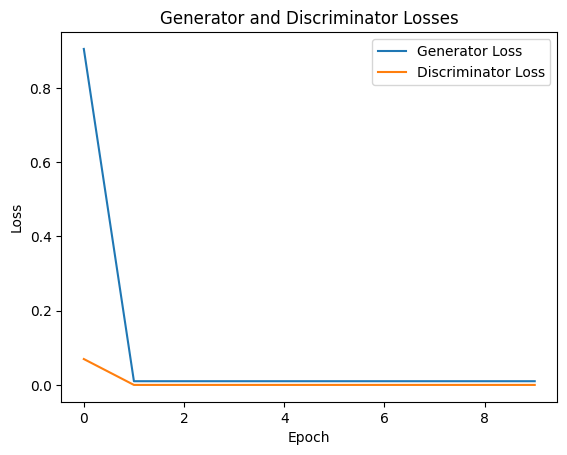

In [52]:
plot_loss(losses_G, losses_D)

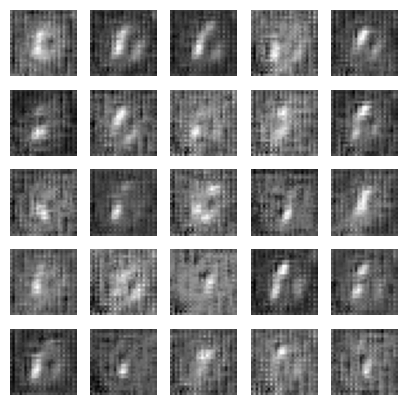

In [53]:
generate_and_plot_images(generator_wgan)

## Validating the WGAN

In [70]:
fid_value = calculate_fid(generator_wgan)
print(f"FID Score: {fid_value}")

100%|██████████| 79/79 [00:17<00:00,  4.46it/s]


FID Score: 157.37894724227624




# SSGAN

In [80]:
class ResidualBlock1(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock1, self).__init__()

        self.block1 = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

    def forward(self, x):
        residual = x
        out = self.block1(x)
        out += residual
        return out

class ResidualBlock2(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock2, self).__init__()

        self.block2 = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2)
        )
        self.mxp = nn.MaxPool2d(4)

    def forward(self, x):
        residual = self.mxp(x)
        out = self.block2(x)
        out += residual
        return out

class SSGAN_Generator(nn.Module):
    def __init__(self):
        super(SSGAN_Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(128, 256*4*4),
            nn.BatchNorm1d(256*4*4),
            nn.ReLU(),

            ResidualBlock1(256, 256),
            ResidualBlock1(256, 256),
            ResidualBlock1(256, 256),
            nn.ReLU(),

            nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.Tanh()
        )

    def forward(self, z):
        #return self.model(z.view(z.size(0), -1, 1, 1))
        return self.model(z)

class SSGAN_Discriminator(nn.Module):
    def __init__(self):
        super(SSGAN_Discriminator, self).__init__()
        self.model = nn.Sequential(
            ResidualBlock2(1, 128),
            ResidualBlock2(128, 128),
            ResidualBlock2(128, 128),

            nn.Flatten(),
            nn.Linear(128, 1),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        return self.model(x)

## Training the SSGAN

In [81]:
alpha = 0.1
beta = 0.1

generator_ssgan = SSGAN_Generator().to(device)
discriminator_ssgan = SSGAN_Discriminator().to(device)

optimizer_G_ss = optim.Adam(generator_ssgan.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_ss = optim.Adam(discriminator_ssgan.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion_BCE = nn.BCEWithLogitsLoss()


In [ ]:
losses_G = []
losses_D = []

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Training Discriminator
        optimizer_D_ss.zero_grad()

        real_output = discriminator_ssgan(real_images)
        loss_real = criterion_BCE(real_output, torch.ones_like(real_output).to(device))

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator_ssgan(z)
        fake_output = discriminator_ssgan(fake_images.detach())
        loss_fake = criterion_BCE(fake_output, torch.zeros_like(fake_output).to(device))

        # Rotation-based loss for the discriminator
        #rotated_images = torch.rot90(real_images, k=1, dims=(2, 3))
        rotated_images = torch.rot90(real_images.cpu(), k=1, dims=(2, 3)).to(device)
        prob_rotation = discriminator_ssgan(rotated_images)
        loss_rotation_D = -beta * torch.mean(prob_rotation)

        # Discriminator loss
        loss_D = loss_real + loss_fake + loss_rotation_D
        loss_D.backward()
        optimizer_D_ss.step()

        # Training Generator
        optimizer_G_ss.zero_grad()
        fake_output = discriminator_ssgan(fake_images)
        loss_G = criterion_BCE(fake_output, torch.ones_like(fake_output).to(device))

        # Rotation-based loss for the generator
        prob_rotation_gen = discriminator_ssgan(torch.rot90(fake_images, k=1, dims=(2, 3)))
        loss_rotation_G = alpha * torch.mean(prob_rotation_gen)

        # Generator loss
        loss_G_total = loss_G + loss_rotation_G
        loss_G_total.backward()
        optimizer_G_ss.step()

        if i % 500 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i<4}/{len(train_loader)}],"
                  f"Discriminator Loss: {loss_D.item():.4f}, Generator Loss: {loss_G.item():.4f}")

    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    if (epoch == 0) or (epoch == epochs/2):
        generate_and_plot_images(generator_ssgan)


In [ ]:
# Plot losses_G and losses_D after training
plot_loss(losses_G, losses_D)

In [ ]:
# Show generated images after training
generate_and_plot_images(generator_ssgan)

In [ ]:
fid_value = calculate_fid(generator_ssgan)
print(f"FID Score: {fid_value}")